In [1]:
# Let's start by installing the necessary libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression
import warnings
import requests
from io import StringIO
warnings.filterwarnings("ignore")

In [2]:
# URL of the CSV file on the GitHub repository
url = 'https://raw.githubusercontent.com/lorenzilarissa/gold-price-forecasting/main/gold_monthly_csv.csv'

# Read the CSV file from the URL
response = requests.get(url)
data = response.content.decode('utf-8')

# Create a DataFrame from the CSV data
df = pd.read_csv(StringIO(data))

# Displaying the information about the gold price data
print(f"Wow, we got ourselves some gold prices here! This data has {df.shape[0]} rows and {df.shape[1]} columns.")
print(f"The gold price data goes all the way back from {df.loc[:, 'Date'].iloc[0]} to {df.loc[:, 'Date'].iloc[-1]}")
df.head()

Wow, we got ourselves some gold prices here! This data has 847 rows and 2 columns.
The gold price data goes all the way back from 1950-01 to 2020-07


,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [3]:
# Create a new dataframe with monthly dates as the index
date_range = pd.date_range(start='1/1/1950', end='8/1/2020', freq='M')
df['month'] = date_range
df.drop('Date', axis=1, inplace=True)
df = df.set_index('month')
df.head()

,Price
month,
1950-01-31,34.73
1950-02-28,34.73
1950-03-31,34.73
1950-04-30,34.73
1950-05-31,34.73


<Figure size 2000x800 with 0 Axes>

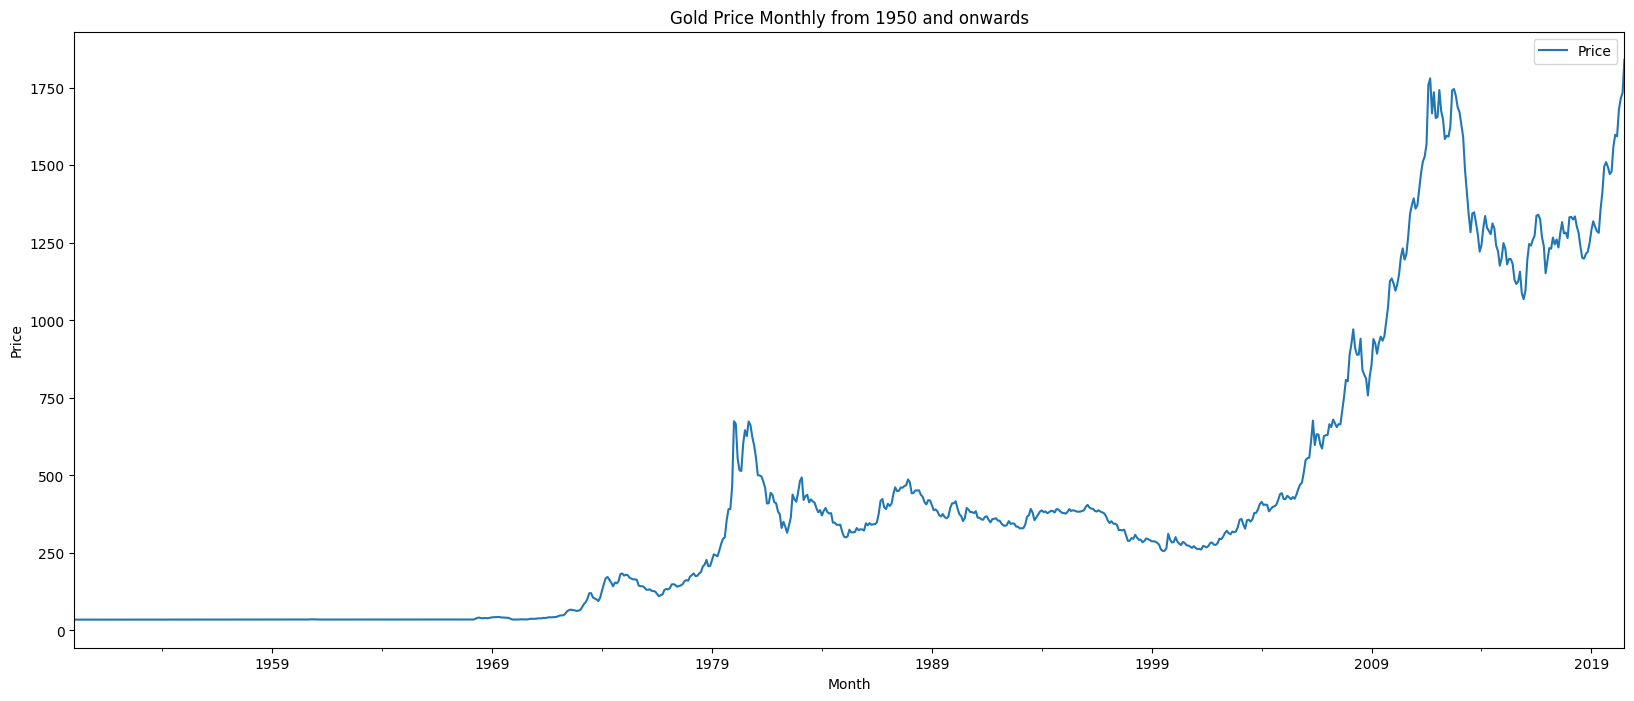

In [4]:
# Time for some visualizations! Let's plot the gold prices over time
plt.figure(figsize=(20,8))
df.plot(figsize=(20,8))
plt.title('Gold Price Monthly from 1950 and onwards')
plt.xlabel('Month')
plt.ylabel('Price')
plt.show()

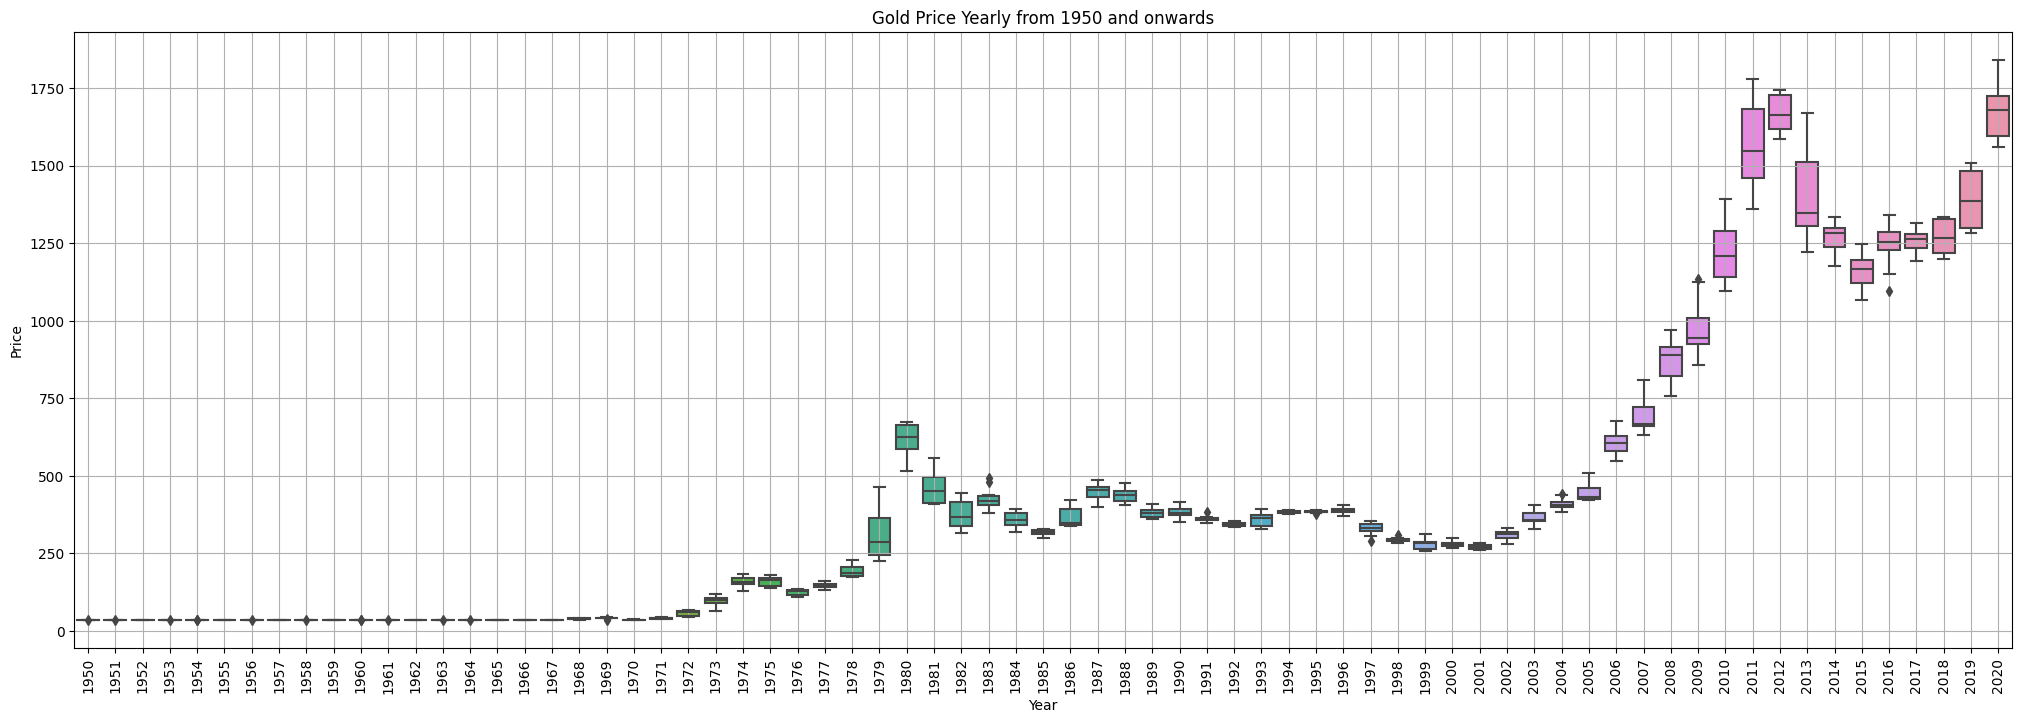

In [5]:
# How about a cool boxplot of the gold prices by year?
plt.figure(figsize=(25,8))
sns.boxplot(x=df.index.year, y=df.values[:,0])
plt.title('Gold Price Yearly from 1950 and onwards')
plt.xlabel('Year')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [6]:
# Curious to know the summary statistics of the gold prices?
print("Alright, let's spill the beans! Here are the summary statistics of gold prices:\n", df.describe())

Alright, let's spill the beans! Here are the summary statistics of gold prices:
              Price
count   847.000000
mean    416.556906
std     453.665313
min      34.490000
25%      35.190000
50%     319.622000
75%     447.029000
max    1840.807000


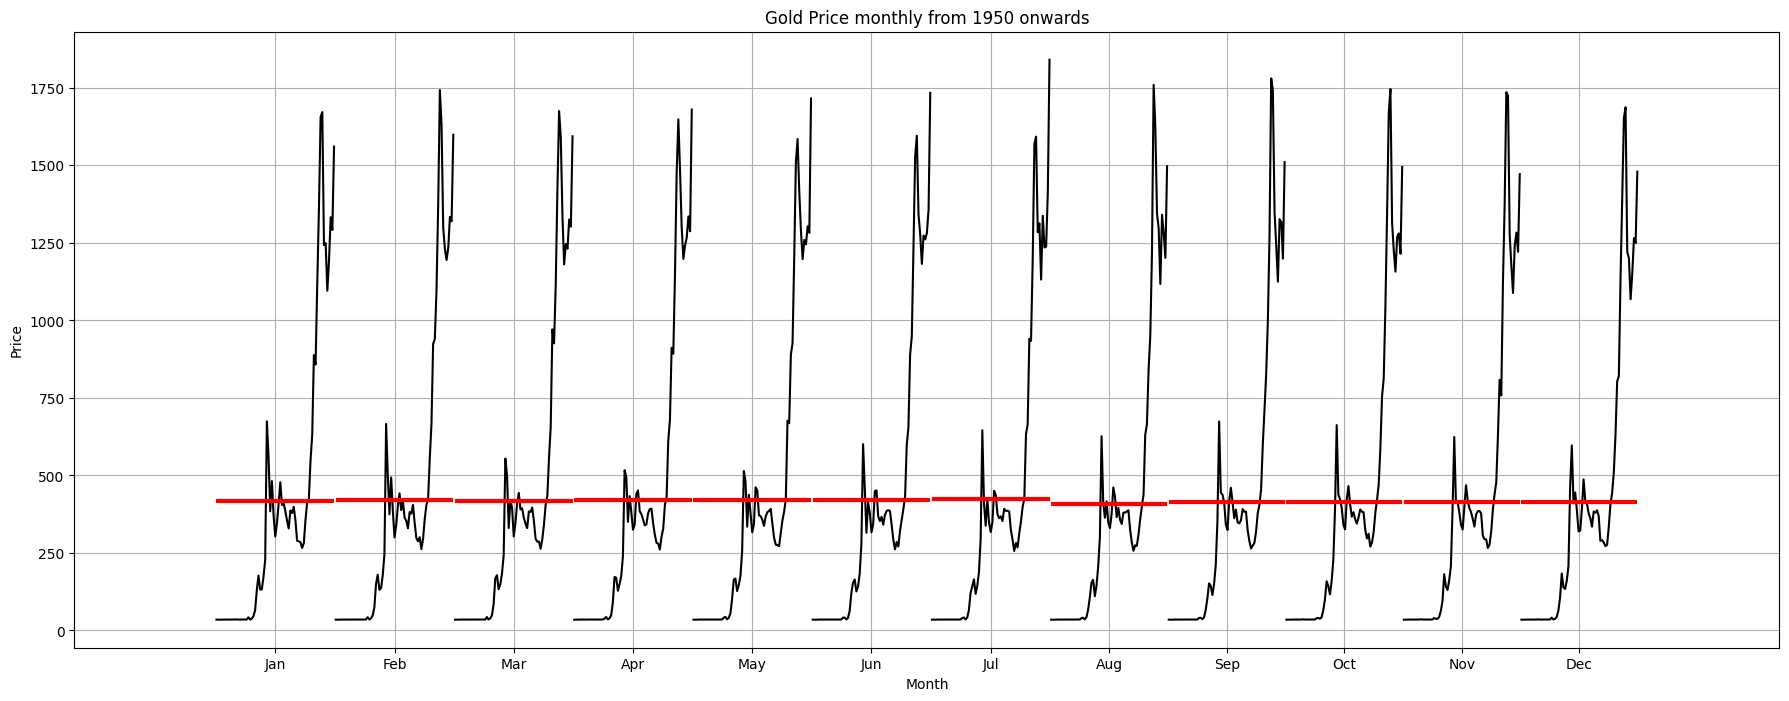

In [7]:
# Let's see how the gold prices behave by month with a fancy plot
from statsmodels.graphics.tsaplots import month_plot

fig, ax = plt.subplots(figsize=(22,8))
month_plot(df, ylabel='Gold Price', ax=ax)
plt.title('Gold Price monthly from 1950 onwards')
plt.xlabel('Month')
plt.ylabel('Price')
plt.grid()
plt.show()

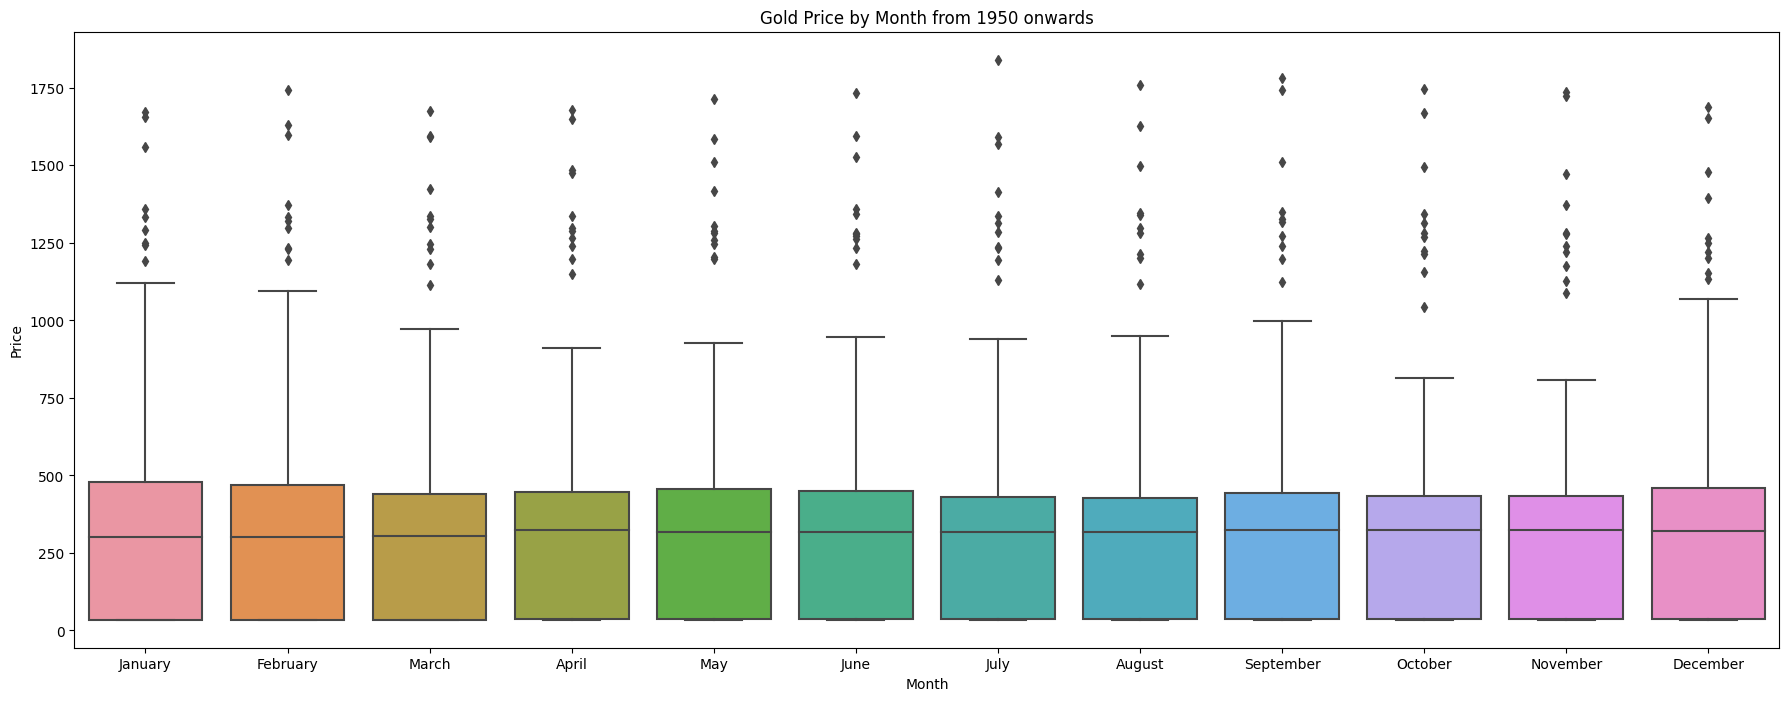

In [8]:
# Now, let's get even fancier with a boxplot of the gold prices by month
fig, ax = plt.subplots(figsize=(22,8))
sns.boxplot(x = df.index.month_name(), y=df.values[:,0], ax=ax)
plt.title('Gold Price by Month from 1950 onwards')
plt.xlabel('Month')
plt.ylabel('Price')
plt.show()

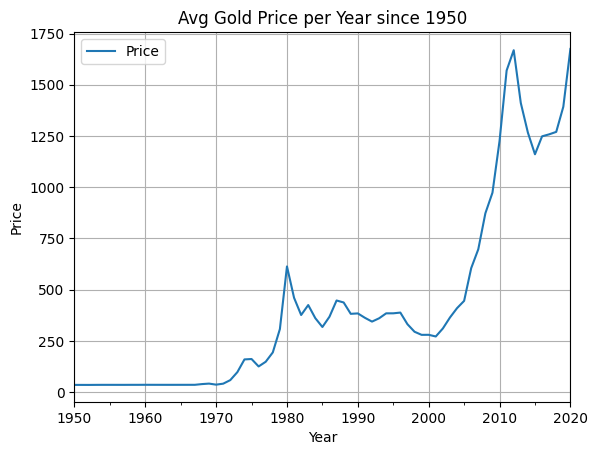

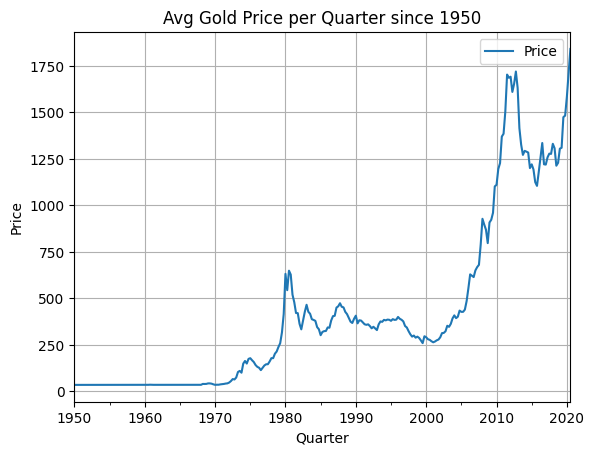

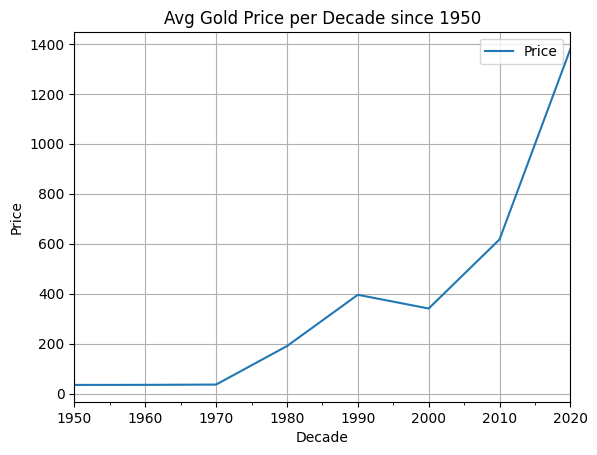

In [9]:
# Time to break it down! Let's create yearly, quarterly, and decade summaries of the data
df_yearly_sum = df.resample('A').mean()
df_yearly_sum.plot()
plt.title('Avg Gold Price per Year since 1950')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid()

df_quarterly_sum = df.resample('Q').mean()
df_quarterly_sum.plot()
plt.title('Avg Gold Price per Quarter since 1950')
plt.xlabel('Quarter')
plt.ylabel('Price')
plt.grid()

df_decade_sum = df.resample('10Y').mean()
df_decade_sum.plot()
plt.title('Avg Gold Price per Decade since 1950')
plt.xlabel('Decade')
plt.ylabel('Price')
plt.grid()
plt.show()

<Figure size 2000x800 with 0 Axes>

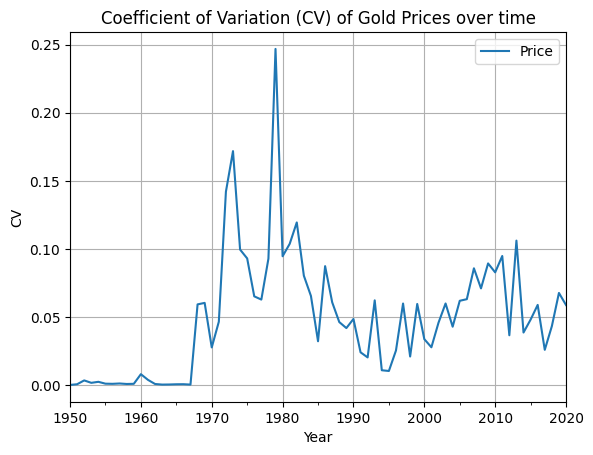

In [10]:
# We're going all in now! Let's calculate the mean, standard deviation, and coefficient of variation (CV) by year
mean_prices = df.resample('A').mean()
std_prices = df.resample('A').std()
cv_prices = std_prices / mean_prices
plt.figure(figsize=(20,8))
cv_prices.plot()
plt.title('Coefficient of Variation (CV) of Gold Prices over time')
plt.xlabel('Year')
plt.ylabel('CV')
plt.grid()
plt.show()

We're gonna split the data like a boss! The training set has 792 rows and the testing set has 55 rows.


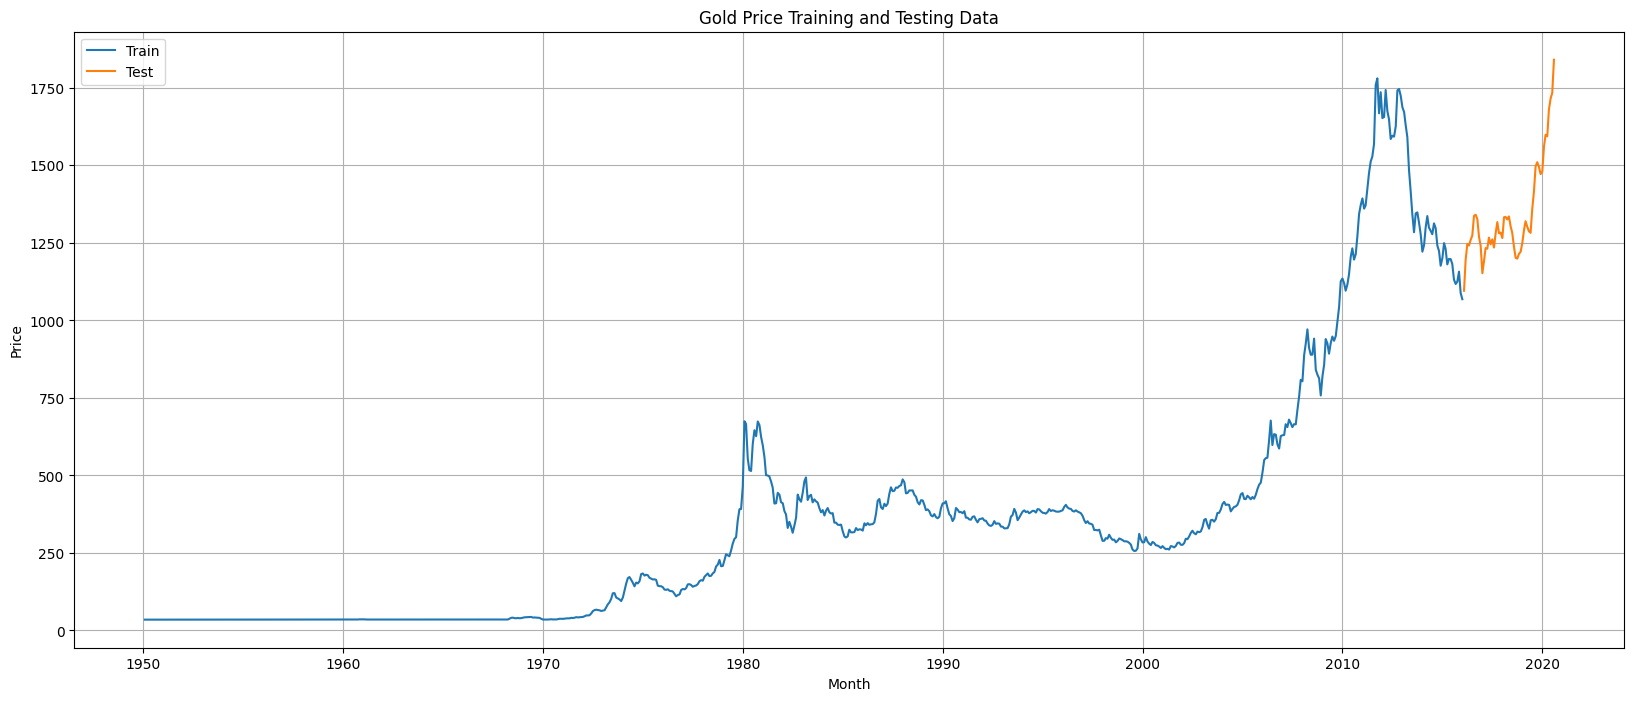

In [11]:
# Now it's time to split the data into training and testing sets
cutoff_year = 2015
train = df.loc[:str(cutoff_year)]
test = df.loc[str(cutoff_year+1):]
print(f"We're gonna split the data like a boss! The training set has {train.shape[0]} rows and the testing set has {test.shape[0]} rows.")

# Let's plot the train and test data on a line graph
plt.figure(figsize=(20,8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.title('Gold Price Training and Testing Data')
plt.xlabel('Month')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

The Linear Regression model is making some predictions, and its Mean Absolute Percentage Error (MAPE) is 29.759658449348564%.


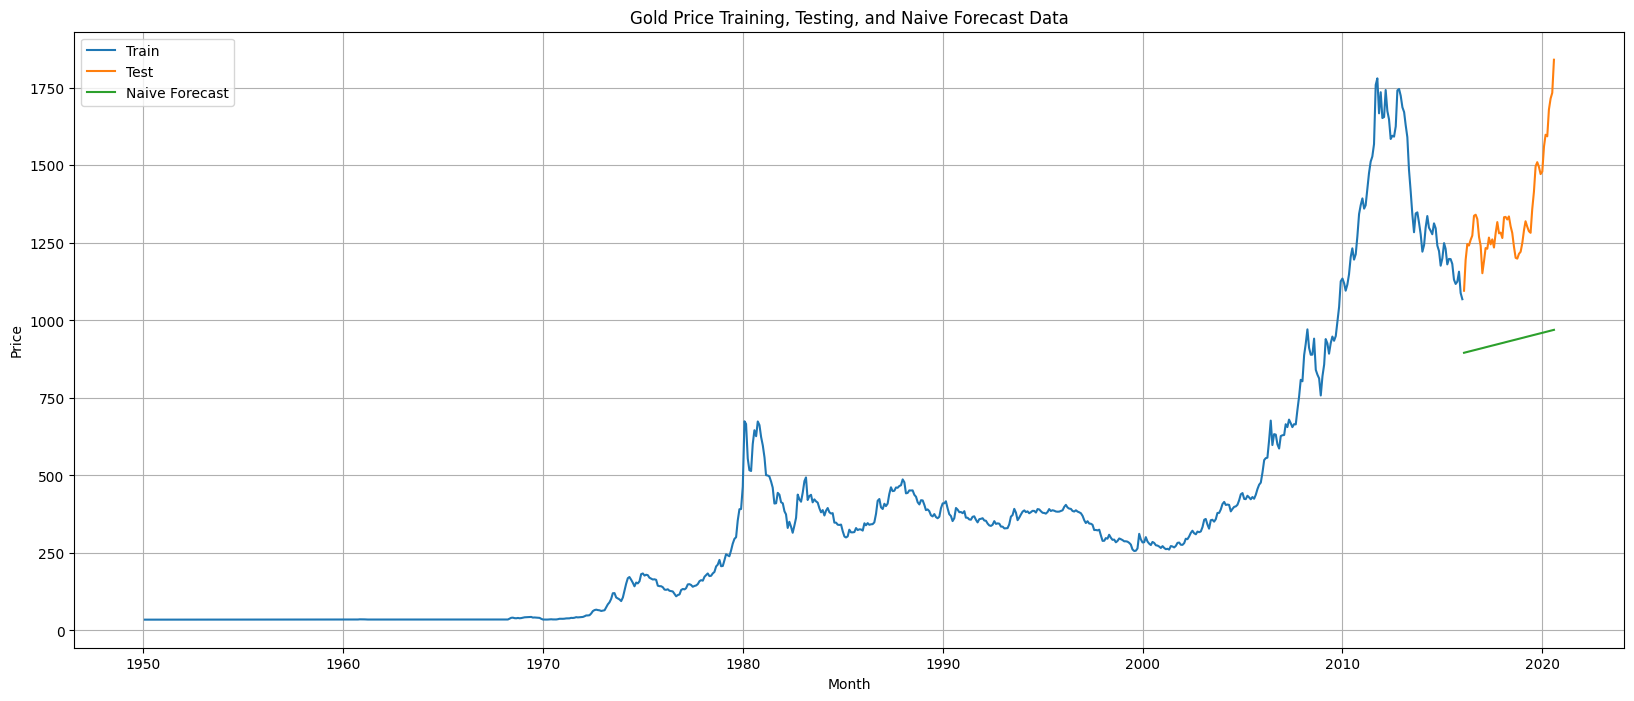

In [12]:
# Creating time series data for the train and test sets
train_ts = pd.Series(train.values[:,0], index=train.index)
test_ts = pd.Series(test.values[:,0], index=test.index)

# Train a linear regression model using the training data
model = LinearRegression()
model.fit(np.arange(len(train)).reshape(-1,1), train_ts)

# Making predictions on the test data using the trained linear regression model
preds = model.predict(np.arange(len(train), len(train)+len(test)).reshape(-1,1))
mape = np.mean(np.abs((test_ts - preds) / test_ts)) * 100
print(f"The Linear Regression model is making some predictions, and its Mean Absolute Percentage Error (MAPE) is {mape}%.")

# Plotting the train data, test data, and naive forecast on the test data
plt.figure(figsize=(20,8))
plt.plot(train_ts, label='Train')
plt.plot(test_ts, label='Test')
plt.plot(test.index, preds, label='Naive Forecast')
plt.title('Gold Price Training, Testing, and Naive Forecast Data')
plt.xlabel('Month')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [13]:
# Create results dataframe to store MAPE values for different models
results = pd.DataFrame({'Test MAPE (%)': [mape]}, index=['Regression on Time'])
results

,Test MAPE (%)
Regression on Time,29.759658


The Naive Forecast model is taking the easy way out, and its Mean Absolute Percentage Error (MAPE) is 19.38458648841945%.


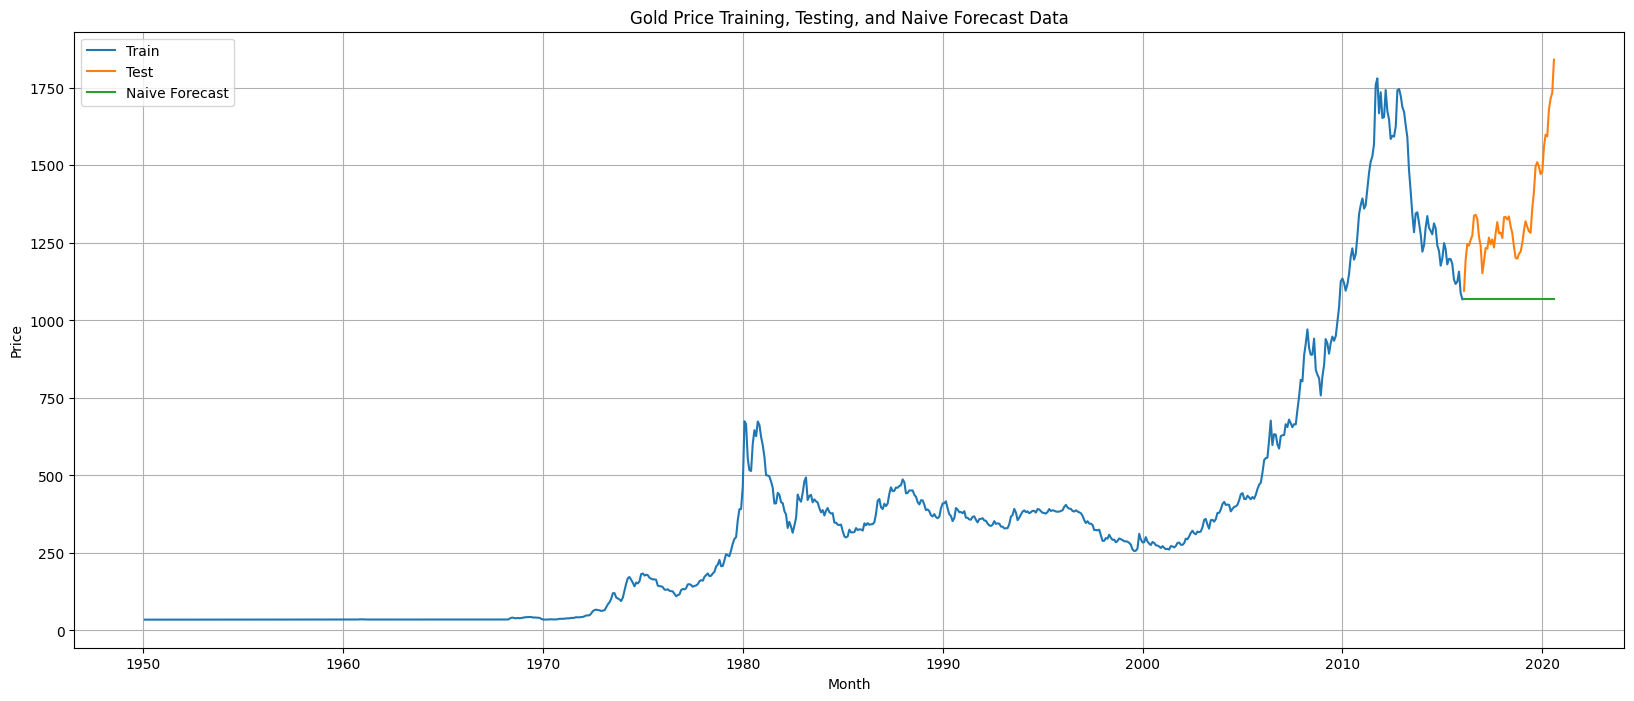

In [14]:
# Creating a dataframe to store the MAPE values for different models, starting with the Linear Regression model
model_comparison = pd.DataFrame({'Model': ['Linear Regression'], 'MAPE': [mape]})

# Let's try a naive forecast model that just assigns the last value of the train set as the forecast for the test set
naive_preds = np.repeat(train_ts.iloc[-1], len(test))
naive_mape = np.mean(np.abs((test_ts - naive_preds) / test_ts)) * 100
print(f"The Naive Forecast model is taking the easy way out, and its Mean Absolute Percentage Error (MAPE) is {naive_mape}%.")

# Plotting the train data, test data, and naive forecast on the test data
plt.figure(figsize=(20,8))
plt.plot(train_ts, label='Train')
plt.plot(test_ts, label='Test')
plt.plot(test.index, naive_preds, label='Naive Forecast')
plt.title('Gold Price Training, Testing, and Naive Forecast Data')
plt.xlabel('Month')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [15]:
# Update the dataframe with the MAPE result for the naive forecast model
resultsDf_2 = pd.DataFrame({'Test MAPE (%)': [naive_mape]}, index=['naiveForecast'])
results = pd.concat([results,resultsDf_2])

# Display the dataframe with the MAPE results for both models
results

,Test MAPE (%)
Regression on Time,29.759658
naiveForecast,19.384586


In [16]:
# Perform exponential smoothing with additive trend and additive seasonality
final_model = ExponentialSmoothing(df, trend='additive', seasonal='additive').fit(
    smoothing_level=0.4, smoothing_trend=0.3, smoothing_seasonal=0.6)

# Get the fitted values from the final model
fitted_values = final_model.fittedvalues

# Calculate mean absolute percentage error (MAPE) using the fitted values
mape_final_model = np.mean(np.abs((test_ts - fitted_values) / test_ts)) * 100
print('MAPE of final model: %.3f%%' % mape_final_model)

MAPE of final model: 7.125%


In [17]:
# Update the dataframe with the MAPE result for the HoltWinters
resultsDf_3 = pd.DataFrame({'Test MAPE (%)': [mape_final_model]}, index=['Holt-Winters'])
results = pd.concat([results,resultsDf_3])
results

,Test MAPE (%)
Regression on Time,29.759658
naiveForecast,19.384586
Holt-Winters,7.124775


In [18]:
best_model = results['Test MAPE (%)'].idxmin()
best_mape = results.loc[best_model, 'Test MAPE (%)']

print("Best Model:", best_model)
print("Test MAPE (%):", best_mape)

Best Model: Holt-Winters
Test MAPE (%): 7.124775321067912


In [19]:
# Generate forecast using the final model
prediction = final_model.forecast(steps=len(test))

# Create a dataframe to store the prediction and confidence intervals
pred_df = pd.DataFrame({
    'lower_CI': prediction - 1.96 * np.std(final_model.resid, ddof=1),
    'prediction': prediction,
    'upper_CI': prediction + 1.96 * np.std(final_model.resid, ddof=1)
})
# Export the predictions into a csv file.
pred_df.to_csv('gold_price_predictions.csv', index=True, index_label='Month') 

print('Prediction and confidence intervals:')
pred_df

Prediction and confidence intervals:


,lower_CI,prediction,upper_CI
2020-08-31,1684.719922,1792.870894,1901.021866
2020-09-30,1615.305634,1723.456606,1831.607579
2020-10-31,1538.567122,1646.718094,1754.869067
2020-11-30,1476.757432,1584.908404,1693.059376
2020-12-31,1459.325790,1567.476763,1675.627735
2021-01-31,1514.415849,1622.566821,1730.717793
2021-02-28,1545.350493,1653.501465,1761.652437
2021-03-31,1556.762428,1664.913401,1773.064373
2021-04-30,1648.307918,1756.458890,1864.609862
2021-05-31,1694.224088,1802.375060,1910.526032


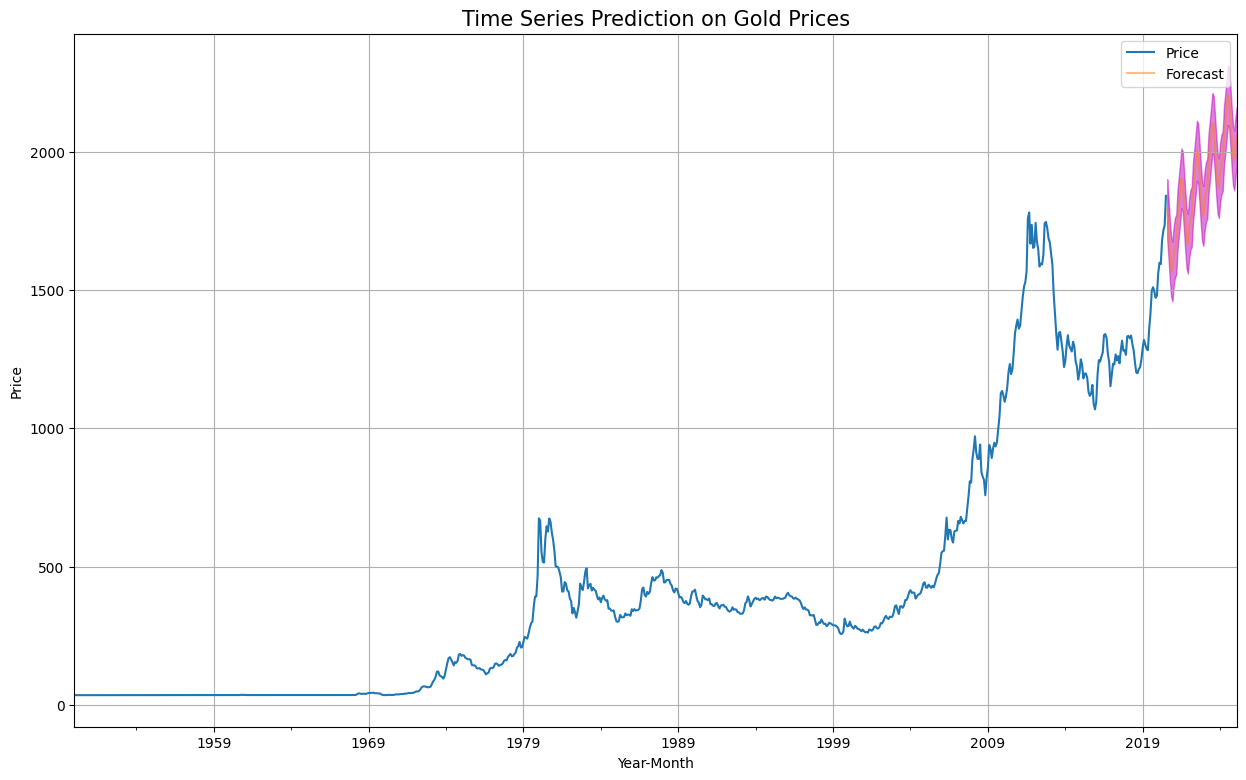

<Figure size 640x480 with 0 Axes>

In [20]:
# Plot actual and predicted values with confidence intervals
axis = df.plot(label='Actual', figsize=(15,9))
pred_df['prediction'].plot(ax=axis, label='Forecast', alpha=0.5)
axis.fill_between(pred_df.index, pred_df['lower_CI'], pred_df['upper_CI'], color='m', alpha=0.5)
axis.set_xlabel('Year-Month')
axis.set_ylabel('Price')
plt.title('Time Series Prediction on Gold Prices',fontsize=15)
plt.legend(loc='best')
plt.grid()
plt.show()

# Save plot as png
plt.savefig('gold_price_predictions.png')

## References
- Kaggle Dataset: [Monthly Gold Price](https://www.kaggle.com/datasets/nhiyen/monthly-gold-price)
- Github Repo - [HERE](https://github.com/yennhi95zz/predict-gold-prices)
- Kaggle Project - [HERE](https://www.kaggle.com/nhiyen/time-series-prediction-on-gold-prices)
- Detail Explanation about the code on [MEDIUM]([https://medium.com/@yennhi95zz/unleashing-the-power-of-e-commerce-sales-analysis-a-case-study-4c64871a86ee](https://medium.com/@yennhi95zz/time-series-prediction-on-gold-prices-a826fc2ead0c))